In [2]:
import requests
import bs4
import scipy.io as scio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import progressbar
from sklearn import cross_validation as cv
from sklearn.model_selection import train_test_split
import random
from surprise import NMF
from surprise import KNNBaseline
from surprise import KNNWithMeans
from surprise import BaselineOnly
from surprise import NormalPredictor
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

c:\softwaress\tools\python3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 一些需要调用的函数

In [4]:
path = "C:/Users/wkl31415926/OneDrive/Projects/CPRS/process/"

### 将一个matrix转为DataSet格式(没有值的地方为NaN)

In [4]:
def matrix_to_col_dataSet(matrix, reader):
    ret = []
    for idx_r,r in enumerate(matrix):
        for idx_c,c in enumerate(r):
            if not np.isnan(c):
                ret.append([idx_r,idx_c,c])
    ret = pd.DataFrame(ret)
    ret.columns = ['userID', 'itemID', 'rating']
    return Dataset.load_from_df(ret[['userID', 'itemID', 'rating']], reader)

## 爬虫部分

### 对于题目难度的估价

In [5]:
def hardness(problemid,score,solvetime):
    if solvetime == None:
        return np.nan
    solvetime = int(solvetime[:2])*60+int(solvetime[3:])
    return int(solvetime)


### 获取某个页面的数据

In [6]:
def getTab(url):
    r = requests.get(url)
    soup = bs4.BeautifulSoup(r.text,'lxml')
    datas = []
    ptitle = []
    for ths in  soup.tr("th")[4:]:
        ptitle += [ths.a["title"][4:]]
    
    for tr in soup(participantid = True):
        tds = tr("td")
        ret = []
        ret += [tds[1].get_text(strip=True)]
        ret += [int(tds[2].get_text(strip=True))]
        ret += [tds[3].get_text(strip=True)+""]
        for i in range(4,len(tds)):
            ret += [hardness(i,
                            tds[i](class_="cell-passed-system-test")[0].get_text(strip=True) 
                            if len(tds[i](class_="cell-passed-system-test")) != 0 
                            else None,
                            tds[i](class_="cell-time")[0].get_text(strip=True) 
                            if len(tds[i](class_="cell-time")) !=0 
                            else None )]
        datas += [ret]
    
    for j, line in enumerate(datas):
        temp = []
        for i in range(3,3+len(ptitle)):
            if not np.isnan(line[i]):
                temp += [[i,line[i]]]
        temp = sorted(temp, key=lambda x:x[1] )
        for i in reversed(range(1,len(temp))):
            temp[i][1]-=temp[i-1][1]
        for item in temp:
            line[item[0]]=item[1]
        datas[j] = line

    return datas,ptitle

### 获取一场比赛的所有数据 传入比赛id

In [7]:
# contest id
def getAll(contest_id):
    print("starting to get Contest "+str(contest_id))
    url = "http://codeforces.com/contest/"+str(contest_id)+"/standings"
    r = requests.get(url)
    soup = bs4.BeautifulSoup(r.text,'lxml')
    lens = len(soup("nobr"))
    ret,title = getTab(url)
    for i in range(2,lens+1):
        print("%"+str((i-1)/lens*100)+" finished")
        nret,_ = getTab(url + "/page/" + str(i))
        ret += nret
    print("all finished")
    return ret,title

### 获取多场比赛的数据，保存为pands，行为选手，纵为题目，NaN为没做
### 传入的contest_id为一个list
### 返回三个内容 problem_names(list),user_names(list),datafile

In [25]:
def getRound(contest_id):
    user = []
    prb = []
    df = []
    for i in contest_id:
        data = []
        title = []
        error_cnt = 0
        while True:
            error_cnt = error_cnt+1
            if error_cnt == 10:
                print("Error=================================================!!!!!!!!!!!!!!!!!!!!!!!!!!!");
                break;
            try:
                data,title = getAll(int(i))
            except Exception:
                print("Exception!");
            else:
                break;
        prb += title
        for i in range(len(data)):
            user.append(data[i][0])
            temp = data[i][-len(title):]
            for j in range(len(temp)):
                if not np.isnan(temp[j]) and temp[j]!=0:
                    df.append([data[i][0],title[j],temp[j]])
    df = pd.DataFrame(df)
    df.columns = ['user_name', 'prb_name', 'time'];
    user = list(set(user))
    prb = list(set(prb))
    return prb,user,df

### 获取所有数据

In [1]:
train = pd.read_csv(path+"train_round.csv")
test = pd.read_csv(path+"test_round.csv")

NameError: name 'pd' is not defined

In [6]:
prb,user,df = getRound(list(train.values)+list(test.values))
df.to_csv(path+"all_data.csv")
pd.DataFrame(prb).to_csv(path+"prb.csv")
pd.DataFrame(user).to_csv(path+"user.csv")

NameError: name 'getRound' is not defined

## 数据获取完毕，开始处理

In [5]:
df = pd.read_csv(path+"all_data.csv")
df = df[['user_name', 'prb_name', 'time']]

### 清洗一下，去除没有做题的人

In [6]:
#统计一个序列里每个值的出现次数,返回一个字典
def build_dic(arr):
    ret = {}
    for i in arr:
        if not i in ret:
            ret[i] = 1
        else:
            ret[i] = ret[i]+1
    return ret

In [7]:
user = build_dic(df["user_name"].values)
prb = build_dic(df["prb_name"].values)
ret = []
threhold = 1
for index, row in df.iterrows():
    if user[row["user_name"]] >= threhold and prb[row["prb_name"]] >= threhold*10 :
        ret.append(list(row))
ret = pd.DataFrame(ret)
ret.columns = df.columns
df = ret

In [9]:
print("users: "+str( len(set(df["user_name"].values)) ) + " problems: "+ str( len(set(df["prb_name"].values)) ) + " Messages: "+ str(df.shape[0]) )


users: 34635 problems: 235 Messages: 302835


### 统计分析

* 每个人做题数量分布

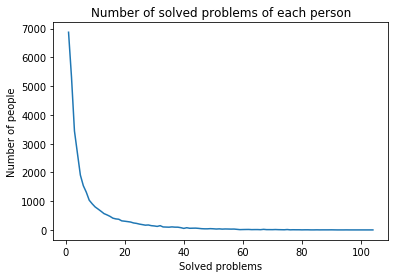

In [9]:
pd.Series(dict(pd.Series(list(user.values())).value_counts(sort = True, normalize = False))).plot( 
    title = "Number of solved problems of each person")
plt.xlabel("Solved problems")
plt.ylabel("Number of people")
plt.show()

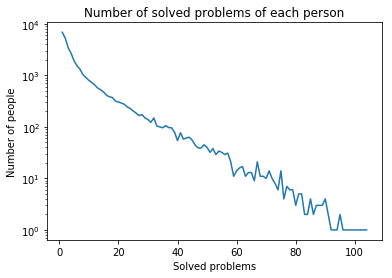

In [10]:
pd.Series(dict(pd.Series(list(user.values())).value_counts(sort = True, normalize = False))).plot( 
    title = "Number of solved problems of each person",logy = True)
plt.xlabel("Solved problems")
plt.ylabel("Number of people")
plt.show()

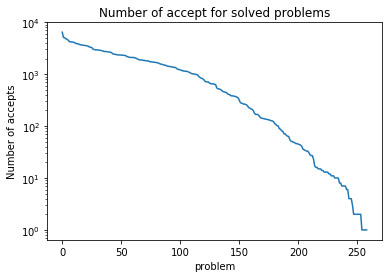

In [11]:
pd.Series( sorted( list(prb.values()) , reverse = True) ).plot( 
    title = "Number of accept for solved problems", logy = True)
plt.xlabel("problem")
plt.ylabel("Number of accepts")
plt.show()

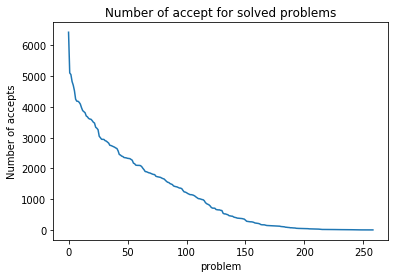

In [12]:
pd.Series( sorted( list(prb.values()) , reverse = True) ).plot( 
    title = "Number of accept for solved problems", logy = False)
plt.xlabel("problem")
plt.ylabel("Number of accepts")
plt.show()

### 开始给用户和题目标号

In [8]:
user_id = {}
cnt = 0

for i in user.keys():
    user_id[i]=cnt
    cnt = cnt+1

prb_id = {}
cnt = 0
for i in prb.keys():
    prb_id[i]=cnt
    cnt = cnt+1

ret = []
for index, row in df.iterrows():
    ret.append( [user_id[row["user_name"]], prb_id[row["prb_name"]], np.log(row["time"]) ] )

ret = pd.DataFrame(ret)
ret.columns = df.columns
df = ret

In [9]:
reader = Reader(rating_scale=(0, 6))
data = Dataset.load_from_df(df, reader)
trainset, testset = train_test_split(data, test_size=0.2)

* 评估获得答案并且评估结果

In [10]:
def evaluate(algo, trainset, testset):
    algo.fit(trainset)
    ret = algo.fit(trainset).test(testset)
    ret = pd.DataFrame(ret)
    delta = np.array(ret["r_ui"]) - np.array(ret["est"])
    print("MAE = " + str(np.mean(np.abs(delta))) )
    plt.hist(delta, bins = 100)
    f = np.array(ret["r_ui"]) / np.array(ret["est"])
    t = np.exp( np.array(ret["r_ui"]) ) / np.exp( np.array(ret["est"]) ) 
    d = np.exp( np.array(ret["r_ui"]) ) - np.exp( np.array(ret["est"]) ) 
    d = np.abs(d)
    print("for eps = 0.3 result:" + str( sum( (f<=1.3)&(f>=0.7)  ) / len(t) ))
    print("for eps1 = 0.3 eps2 = 2 : result:" + str( sum( (t<=1.3)&(t>=0.7)|(d<=2)  ) / len(t) ))
    print("average error on time: " + str(np.mean(d) ) )
    return 

MAE = 0.5553558734005746
for eps = 0.3 result:0.77269800386349
for eps1 = 0.3 eps2 = 2 : result:0.3592385292320901
average error on time: 13.38405573424549


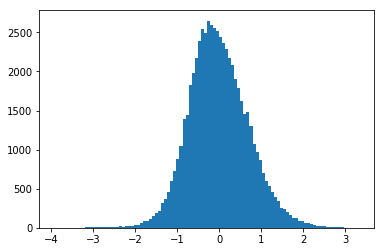

In [11]:
algo = SVD(n_factors = 70, n_epochs = 350, reg_all = 0.04);
evaluate(algo, trainset, testset)

MAE = 1.145729484253205


c:\softwaress\tools\python3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


for eps = 0.3 result:0.43503937007874016
for eps1 = 0.3 eps2 = 2 : result:0.17217542574620032


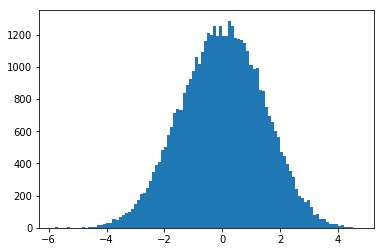

In [17]:
algo = NormalPredictor()
evaluate(algo, trainset, testset)

Estimating biases using als...
Estimating biases using als...
MAE = 0.5341110136229735
for eps = 0.3 result:0.7798937923457242
for eps1 = 0.3 eps2 = 2 : result:0.3836064823292437


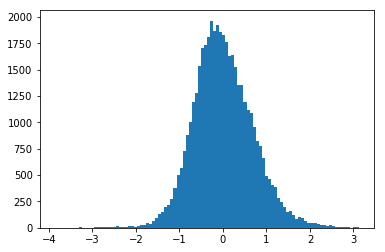

In [18]:
algo = BaselineOnly()
evaluate(algo, trainset, testset)

MAE = 0.5174358623969241
for eps = 0.3 result:0.7949322468412379
for eps1 = 0.3 eps2 = 2 : result:0.3956464017579198


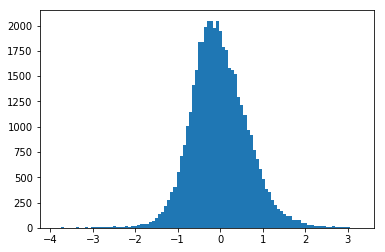

In [19]:
algo = SVD()
evaluate(algo, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE = 0.5790294008411188
for eps = 0.3 result:0.7448956235121773
for eps1 = 0.3 eps2 = 2 : result:0.35316334004761035


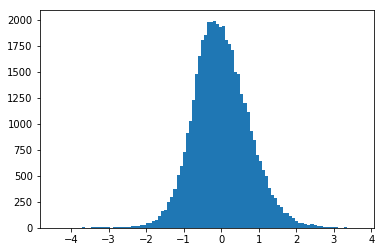

In [20]:
algo = KNNWithMeans()
evaluate(algo, trainset, testset)

# 最终为选手推荐题目，给出选手用户名，推荐前十道题

In [16]:
#获取需要的推荐
#fitted_algo 传入一个已经fit过的algo
#username 用户名
#expect_time 期望的做题时间
#problem_number 期望的题目数量
def get_suggest(fitted_algo, username, expect_time = 40, problem_number = 10):
    username = user_id.get(username);
    if(username == None):
        return ["Username Error!"];
    ept = np.log(expect_time)
    ans = []
    temp = list(prb_id.keys())
    for i in range(len(prb_id)):
        ret = pd.DataFrame([algo.predict(username, i, clip = False)])
        ans.append( tuple([np.abs(ret["est"][0] - ept) , temp[i]]) )
    ans = sorted(ans)
    ret = []
    for i in range(problem_number):
        ret+=[ans[i][1]]
    ret_id = int(random.random()*len(ret));
    return ret[ret_id];

In [231]:
algo=SVD()
algo.fit(trainset)

In [20]:
get_suggest(algo,"PikMike")

['Ann and Books',
 'Billiard',
 'Shovel Sale',
 'Binary Cards',
 'Restoring the Expression',
 'Pathwalks',
 'Tournament',
 'NN country',
 'Game with Tokens',
 'Elevator']

## WebSocket服务器

In [ ]:
from SimpleWebSocketServer import SimpleWebSocketServer, WebSocket

ServerPort = 2340;

class SimpleEcho(WebSocket):

    def handleMessage(self):
        # echo message back to client
        self.sendMessage( get_suggest(algo, self.data) );

    def handleConnected(self):
        print(self.address, 'connected')

    def handleClose(self):
        print(self.address, 'closed')

server = SimpleWebSocketServer('', ServerPort, SimpleEcho)
server.serveforever()

('127.0.0.1', 61614) connected
('127.0.0.1', 61614) closed
('127.0.0.1', 61667) connected
('127.0.0.1', 61667) closed
('127.0.0.1', 61696) connected
('127.0.0.1', 61696) closed
('127.0.0.1', 61733) connected
('127.0.0.1', 61733) closed
('127.0.0.1', 63392) connected
('127.0.0.1', 63392) closed
('127.0.0.1', 64634) connected
('127.0.0.1', 64634) closed
('127.0.0.1', 64814) connected
('127.0.0.1', 64814) closed
('127.0.0.1', 64964) connected
('127.0.0.1', 64964) closed
('127.0.0.1', 65109) connected
('127.0.0.1', 65109) closed
('127.0.0.1', 65526) connected
('127.0.0.1', 65526) closed
